# ΙΑΚΩΒΟΣ ΕΥΔΑΙΜΩΝ p3130059 ΤΜΗΜΑ ΠΛΗΡΟΦΟΡΙΚΗΣ

# ImageCLEF Medical Caption Task 2019

The [Image CLEF 2019 Concept Detection Task](https://www.imageclef.org/2019/medical/caption/) is a large-scale multi-label classification task aiming to identify medical terms (concepts) in radiology images. Implement a system to classify a medical image based on several abnormalities represented by [Unified Medical Language System (UMLS)](https://www.nlm.nih.gov/research/umls/index.html) concept IDs.

The AUEB NLP Group won the competition with [this paper](http://nlp.cs.aueb.gr/pubs/paper_136.pdf). This assignment was prepared by Vasiliki Kougia and John Pavlopoulos.

## Get the Data

* The training data exist in Google Drive.

* You can download the training and validation data from <https://drive.google.com/uc?id=1UOccw0VNCiRTwaQSEJMhiYWXhizvKptX> and the test data from <https://drive.google.com/uc?id=1diO2apPPFJeTH8CGcd3S55OUNTXtJVu2>. Alternatively, you can use the [gdown](https://github.com/wkentaro/gdown) utility; the file IDs are `1UOccw0VNCiRTwaQSEJMhiYWXhizvKptX` and `1diO2apPPFJeTH8CGcd3S55OUNTXtJVu2`.

* The data are organised as follows:

  * `training-set`: 56,629 training images.
  
  * `validation-set`: 14,157 validation images.

  * `Last`; rename it to `test-set`: 10,000 images used for testing. The test images have no annotations. They will be used for assessment.
  
  * `train_concepts.csv`: the image IDs of the training set with their gold (i.e., known correct) tags, separated with `;`.
  
  * `val_concepts.csv`: the validation image IDs with their gold tags, separated with `;`.

  * `string_concepts.csv`: all the available tag IDs and their corresponding name, separated with tabs.

Κάνουμε import όλα τα απαραίτητα πακέτα

In [1]:
import numpy as np
import datetime as dt 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import logit
import math
%matplotlib inline

In [2]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
import tensorflow as tf
from tensorflow.keras import  layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, ZeroPadding2D, AveragePooling2D, Concatenate, BatchNormalization, Activation,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import ImageDataGenerator
import os

## Data Exploration

* Explore your data.

* Plot some images.

* For those images, fetch their tag IDs and their tag names.

* How many tags are there in total?

* Which ones are the most frequent?

* How many tags are there per image?

ΒΛΕΠΟΥΜΕ ΤΑ ΑΡΧΕΙΑ ΠΟΥ ΥΠΑΡΧΟΥΝ ΣΤΟ UNZIP DIRECTORY ΠΟΥ ΔΗΜΙΟΥΡΓΗΘΗΚΕ ΑΦΟΥ ΚΑΤΕΒΑΣΑΜΕ ΤΑ ΑΡΧΕΙΑ ΜΑΣ

In [3]:
def list_files(start_path, num_files):
    for root, dirs, files in os.walk(start_path):
        level = root.replace(start_path, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(indent + os.path.basename(root) + '/', end='')
        if len(files) != 0:
            print()
        sub_indent = ' ' * 4 * (level + 1)
        print(sub_indent, end='')
        for i, f in enumerate(files):
            print(f, end=' ')
            if i == num_files - 1:
                break
        print()

In [4]:
PATH = 'ImageCLEF2019'
list_files(PATH, 5)

ImageCLEF2019/
    string_concepts.csv training-set.zip train_concepts.csv validation-set.zip val_concepts.csv 
    training-set/
        ROCO_CLEF_00000.jpg ROCO_CLEF_00001.jpg ROCO_CLEF_00003.jpg ROCO_CLEF_00004.jpg ROCO_CLEF_00005.jpg 
    validation-set/
        ROCO_CLEF_00002.jpg ROCO_CLEF_00006.jpg ROCO_CLEF_00010.jpg ROCO_CLEF_00012.jpg ROCO_CLEF_00016.jpg 


ΦΟΡΤΩΝΟΥΜΕ ΤΑ 3 CSV ΑΡΧΕΙΑ ΜΕ ΤΙΣ ΕΙΚΟΝΕΣ ΚΑΙ ΤΑ TAGS ΤΟΥΣ. ΤΟ ΠΡΩΤΟ ΑΠΟΤΕΛΕΙ ΤΑ TRAINING DATA ΤΟ ΔΕΥΤΕΡΟ TA VALIDATION DATA ΚΑΙ ΤΟ ΤΡΙΤΟ ΤΟ ΚΑΘΕ TAG ΜΕ ΤΗΝ ΣΗΜΑΣΙΑ ΤΟΥ. ΠΑΡΑΚΑΤΩ ΕΜΦΑΝΙΖΟΥΜΕ ΤΑ 5 ΠΡΩΤΑ ΣΤΟΙΧΕΙΑ ΑΠΟ ΤΑ 3 DATAFRAMES

In [5]:
#Read csv files
PATH = 'ImageCLEF2019'
filepath_train= 'ImageCLEF2019/train_concepts.csv'
filepath_val= 'ImageCLEF2019/val_concepts.csv'
filepath_string = 'ImageCLEF2019/string_concepts.csv'
train_con = pd.read_csv(filepath_train)
val_con = pd.read_csv(filepath_val)
string_con = pd.read_csv(filepath_string,sep='\t',header=None,names=['tag', 'name'])

In [6]:
train_con.head()

,image,tags
0,ROCO_CLEF_07350,C0203126;C0203051
1,ROCO_CLEF_19073,C0772294;C0023884;C0221198;C0412555;C0041618
2,ROCO_CLEF_60501,C0233492;C2985494;C0262950;C1306232
3,ROCO_CLEF_05564,C0521530;C0817096
4,ROCO_CLEF_55020,C0935598;C1184743


In [7]:
val_con.head()

,image,tags
0,ROCO_CLEF_64017,C0001074;C3203359;C0041618
1,ROCO_CLEF_39073,C0027530;C1610719;C0065967;C1704258;C0883242;C...
2,ROCO_CLEF_18028,C1265876;C1293134;C0029053;C0034579;C0025066;C...
3,ROCO_CLEF_02052,C0040426;C1962945;C0043299;C0036849;C0150312
4,ROCO_CLEF_67927,C0184666;C4085643;C4049705;C4049706;C4321335;C...


In [8]:
string_con.head()

,tag,name
0,C0032143,r-tpa
1,C0225516,lower hypopharyngeal region
2,C0825429,bone surface
3,C0020461,excessive potassium in the blood
4,C0947912,proximal muscle weakness due to defect at the ...


ΒΛΕΠΟΥΜΕ ΠΟΣΕΣ TRAINING KAI VALIDATION IMAGES EXOYME

In [9]:
train_dir = os.path.join(PATH, 'training-set')
validation_dir = os.path.join(PATH, 'validation-set')

In [10]:
num_train = len(os.listdir(train_dir))
num_val = len(os.listdir(validation_dir))
print("Total training images:", num_train)
print("Total validation images:", num_val)

Total training images: 56629
Total validation images: 14157


In [11]:
batch_size = 128
IMG_HEIGHT = 224
IMG_WIDTH = 224

ΠΑΡΑΚΑΤΩ ΘΑ ΧΡΗΣΙΜΟΠΟΙΗΣΟΥΜΕ ΤΟΝ IMAGEDATAGENERATOR KANONΤΑΣ RESCALE ΚΑΙ ΤΗΝ ΜΕΘΟΔΟ ΤΟΥ FLOW_FROM_DATAFRAME ΟΠΟΥ ΧΡΗΣΙΜΟΠΟΙΩΝΤΑΣ ΤΟ DATAFRAME ΦΟΡΤΩNΟΥΜΕ ΤΙΣ TRAINING ΕΙΚΟΝΕΣ ΩΣΤΕ ΝΑ ΤΙΣ ΕΜΦΑΝΙΣΟΥΜΕ ΑΡΓΟΤΕΡΑ ΜΑΖΙ ΜΕ ΤΑ TAGS ΤΟΥΣ. ΓΙΑ ΝΑ ΤΟ ΚΑΝΟΥΜΕ ΘΑ ΧΡΗΣΙΜΟΠΟΙΗΣΟΥΜΕ ΕΝΑ ΑΝΤΙΓΡΑΦΟ ΤΟΥ TRAINING DATAFRAME ΠΟΥ ΘΑ ΧΡΗΣΙΜΟΠΟΙΟΥΜΕ ΑΠΟ ΕΔΩ ΚΑΙ ΣΤΟ ΕΞΗΣ ΩΣΤΕ ΝΑ ΕΠΕΞΕΡΓΑΖΟΜΑΣΤΕ ΣΕ ΑΥΤΟ ΤΙΣ ΕΓΓΡΑΦΕΣ ΤΟΥ DATAFRAME

In [12]:

train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data



TO NEO EΠΕΞΕΡΓΑΣΜΕΝΟ TRAINING DATAFRAME

In [13]:
train_c = train_con.copy()
train_c["tags"] = train_c["tags"].apply(lambda x:x.split(";"))
train_c["ind"] = train_c.index
train_c["image"] = train_c["image"].astype(str) +'.jpg'
train_c.head()

,image,tags,ind
0,ROCO_CLEF_07350.jpg,"[C0203126, C0203051]",0
1,ROCO_CLEF_19073.jpg,"[C0772294, C0023884, C0221198, C0412555, C0041...",1
2,ROCO_CLEF_60501.jpg,"[C0233492, C2985494, C0262950, C1306232]",2
3,ROCO_CLEF_05564.jpg,"[C0521530, C0817096]",3
4,ROCO_CLEF_55020.jpg,"[C0935598, C1184743]",4


ΕΔΩ ΧΡΗΣΙΜΟΠΟΙΟΥΜΕ ΤΟΝ GENERATOR ΓΙΑ ΝΑ ΦΟΡΤΩΣΟΥΜΕ ΤΙΣ TRAINING IMAGES ΚΑΙ ΕΠΕΙΤΑ ΤΙΣ ΕΜΦΑΝΙΖΟΥΜΕ ΜΕ ΤΑ ΕΚΑΣΤΟΤΑ TAGS ΤΟΥΣ. ΕΠΙΠΛΕΟΝ ΟΙ ΕΙΚΟΝΕΣ ΑΥΤΕΣ ΦΟΡΤΩΝΟΝΤΑΙ ΜΕ ΝΕΕΣ ΔΙΑΣΤΑΣΕΙΣ 224X224 

In [19]:
train_data = train_image_generator.flow_from_dataframe(batch_size=batch_size,
                                                           dataframe = train_c,
                                                           directory=train_dir,
                                                           shuffle=False,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           x_col = "image",
                                                           y_col = "ind",
                                                           class_mode= "other")

Found 56629 validated image filenames.


In [22]:
#Plot some images
def plot_images(images_arr, lb):
    fig, axes = plt.subplots(10, 1, figsize=(20,20))
    axes = axes.flatten()
    for img, l,ax in zip( images_arr, lb,axes):
        ax.imshow(img)
        tl = train_c.iloc[l]['tags']
        ax.set_title(tl)
        ax.title
        ax.axis('off')

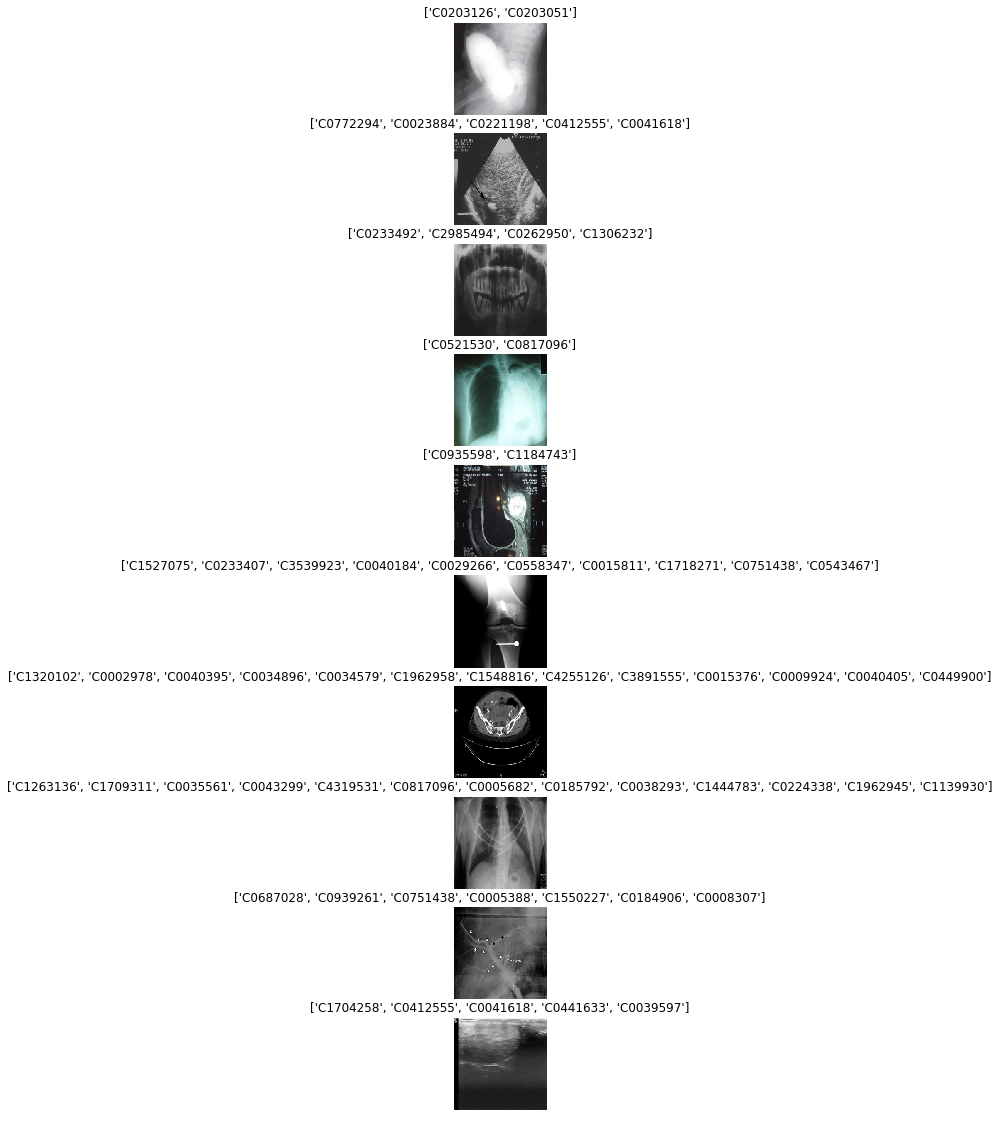

In [23]:
sample_training_images,lab = next(train_data)
plot_images(sample_training_images[:10], lab[:10])

ΕΔΩ ΧΡΗΣΙΜΟΠΟΙΟΥΜΕ ΕΝΑ ΝΕΟ ΑΝΤΙΓΡΑΦΟ ΤΟΥ ΑΡΧΙΚΟΥ TRAINING DATAFRAME ΩΣΤΕ ΝΑ ΕΞΕΤΑΣΟΥΜΕ ΤΟ BALANCE ΤΩΝ ΚΛΑΣΕΩΝ ΚΑΘΩΣ ΚΑΙ ΝΑ ΕΞΑΓΟΥΜΕ ΚΑΙ ΑΛΛΕΣ ΧΡΗΣΙΜΕΣ ΠΛΗΡΟΦΟΡΙΕΣ ΓΙΑ ΤΙΣ ΚΛΑΣΕΙΣ. ΣΤΟ ΝΕΟ DATAFRAME ΠΟΥ ΔΗΜΙΟΥΡΓΟΥΜΕ ΕΧΟΥΜΕ ΠΟΛΛΑΠΛΕΣ ΕΓΓΡΑΦΕΣ ΤΗΣ ΙΔΙΑΣ ΦΩΤΟΓΡΑΦΙΑΣ ΜΕ ΤΟ ΚΑΘΕ ΕΝΑ ΔΙΑΦΟΡΕΤΙΚΟ TAG ΠΟΥ ΕΧΕΙ

In [14]:
train_csv = train_con.copy()
s = train_csv['tags'].str.split(';').apply(pd.Series, 1).stack()
s.index = s.index.droplevel(-1) # to line up with train_csv's index
s.name = 'tags' # needs a name to join
del train_csv['tags']
train_csv = train_csv.join(s)
train_csv=train_csv.reset_index(drop=True)

In [15]:
train_csv.head()

,image,tags
0,ROCO_CLEF_07350,C0203126
1,ROCO_CLEF_07350,C0203051
2,ROCO_CLEF_19073,C0772294
3,ROCO_CLEF_19073,C0023884
4,ROCO_CLEF_19073,C0221198


ΓΚΡΟΥΠΑΡΟΥΜΕ ΤΟ ΝΕΟ DATAFRAME ΑΝΑ TAGS ΚΑΙ ΜΕΤΡΑΜΕ ΠΟΣΕΣ ΕΙΚΟΝΕΣ ΑΝΗΚΟΥΝ ΑΝΑ TAG ΚΑΙ ΤΑ ΤΑΞΙΝΟΜΟΥΜΕ ΣΕ ΦΘΙΝΟΥΣΑ ΣΕΙΡΑ ΩΣΤΕ ΝΑ ΕΜΦΑΝΙΖΟΝΤΑΙ ΠΡΩΤΑ ΤΑ ΤΑGS ΣΤΑ ΟΠΟΙΑ ΑΝΗΚΟΥΝ ΟΙ ΠΕΡΙΣΣΟΤΕΡΕΣ ΦΩΤΟΓΡΑΦΙΕΣ

In [16]:
dt = train_csv.groupby(['tags']).count().reset_index()
dt = dt.sort_values('image', ascending=False)
dt

,tags,image
2634,C0441633,6733
1024,C0043299,6321
4570,C1962945,6318
937,C0040395,6235
793,C0034579,6127
3456,C0817096,5981
940,C0040405,5801
4174,C1548003,5159
1749,C0221198,4513
3412,C0772294,4512


ΕΔΩ ΒΛΕΠΟΥΜΕ ΟΤΙ ΧΡΗΣΙΜΟΠΟΙΟΥΝΤΑΙ 5216 TAGS ΑΠΟ ΤΙΣ TRAINING IMAGES AΠΟ ΤΑ 5528 ΠΟΥ ΕΧΟΥΜΕ ΣΥΝΟΛΙΚΑ

In [17]:
print("Total tags in use: "+str(dt.shape[0]))
print("Total tags: "+str(string_con.shape[0]))

Total tags in use: 5216
Total tags: 5528


ΓΚΡΟΥΠΑΡΟΥΜΕ ΤΟ ΝΕΟ DATAFRAME ΑΝΑ IMAGES ΚΑΙ ΜΕΤΡΑΜΕ ΠΟΣΑ TAGS ΑΝΗΚΟΥΝ ΑΝΑ ΕΙΚΟΝΑ ΚΑΙ ΤΑ ΤΑΞΙΝΟΜΟΥΜΕ ΣΕ ΦΘΙΝΟΥΣΑ ΣΕΙΡΑ ΩΣΤΕ ΝΑ ΕΜΦΑΝΙΖΟΝΤΑΙ ΠΡΩΤΑ ΟΙ ΕΙΚΟΝΕΣ ΠΟΥ ΕΧΟΥΝ ΤΑ ΠΕΡΙΣΣΟΤΕΡΑ TAGS ΔΗΛΑΔΗ ΑΝΗΚΟΥΝ ΣΤΑ ΠΕΡΙΣΣΟΤΕΡΑ CONCEPTS

In [18]:
dt2 = train_csv.groupby('image').count().reset_index()
dt2 = dt2.sort_values('tags', ascending=False)
dt2

,image,tags
55486,ROCO_CLEF_69357,72
37295,ROCO_CLEF_46672,70
35775,ROCO_CLEF_44813,69
2863,ROCO_CLEF_03622,64
12180,ROCO_CLEF_15228,56
28138,ROCO_CLEF_35223,45
32046,ROCO_CLEF_40118,43
28061,ROCO_CLEF_35132,40
22088,ROCO_CLEF_27639,39
30578,ROCO_CLEF_38324,39


In [19]:
#how many tags are assigned to only one image
xd = dt[dt.image == 1].shape[0]
print('Exist '+str(xd)+' images with only one tag')

Exist 1530 images with only one tag


In [20]:
#how many images have only one tag
xs = dt2[dt2.tags == 1].shape[0]
print('Exist '+str(xs)+' tags that are assigned to only one image')

Exist 4239 tags that are assigned to only one image


Κανουμε το plot με τα 50 tags που εμφανιζονται στις περισσοτερες εικόνες

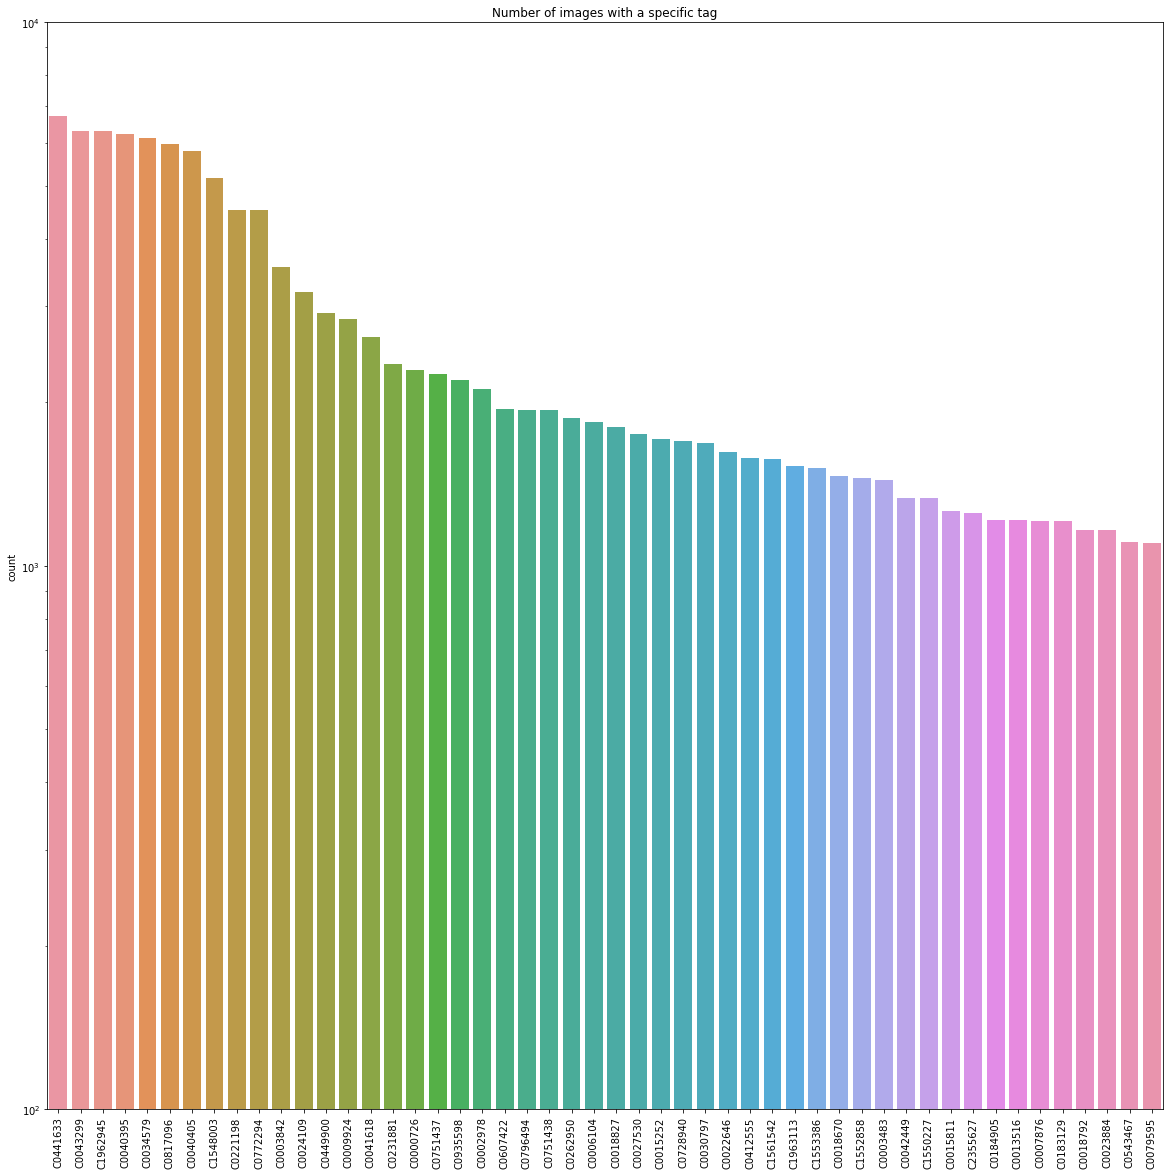

In [21]:
from collections import Counter
fig, ax = plt.subplots(1, 1, figsize=(20,20))
all_labels = [label for lbs in train_c['tags'] for label in lbs]
labels_count = Counter(all_labels)
ax = sns.countplot(all_labels, order=[k for k, _ in labels_count.most_common(50)], log=True)
ax.set_title('Number of images with a specific tag')
ax.set_ylim(1E2, 1E4)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

## Data Preprocessing

* Preprocess the images so that you can use them as input.

* You may have to preprocess the labels as well.

ΠΑΡΑΚΑΤΩ ΘΑ ΧΡΗΣΙΜΟΠΟΙΗΣΟΥΜΕ ΤΟΝ MultiLabelBinarizer ΩΣΤΕ ΝΑ ΜΕΤΑΤΡΕΨΟΥΜΕ ΣΕ ONE HOT ENCODING ΤΑ MULTI-LABEL TAGS MAΣ ΓΙΑ ΤΟ TRAINING SET ΚΑΙ ΤΟ VALIDATION SET. ΓΙΑ ΝΑ ΠΑΡΑΓΟΥΜΕ ONE HOT ENCODING ΘΑ ΧΡΗΣΙΜΟΠΟΙΗΣΟΥΜΕ ΤΑ ΤΑGS ΑΠΟ ΤΟ DATAFRAME string_con ΠΟΥ ΠΕΡΙΕΧΟΝΤΑΙ ΟΛΑ ΤΑ TAGS

In [22]:
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
# Create MultiLabelBinarizer object
mlb = MultiLabelBinarizer()
string_c = string_con.copy()
string_c['tag'] = string_c['tag'].apply(lambda x: [x])
y = string_c['tag'].values
y=list(y)
# One-hot encode data
mlb.fit(y)
df = pd.DataFrame(mlb.transform(train_c['tags']),columns=mlb.classes_)
df.head()

,C0000503,C0000723,C0000726,C0000780,C0000782,C0000790,C0000828,C0000925,C0000934,C0000962,...,C4330491,C4331246,C4331837,C4476838,C4479170,C4479578,C4505257,C4505346,C4505362,C4505478
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
del train_c['ind']
del train_c['tags']
train_c = pd.merge(train_c, df, left_index=True, right_index=True)
train_c.head()

,image,C0000503,C0000723,C0000726,C0000780,C0000782,C0000790,C0000828,C0000925,C0000934,...,C4330491,C4331246,C4331837,C4476838,C4479170,C4479578,C4505257,C4505346,C4505362,C4505478
0,ROCO_CLEF_07350.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ROCO_CLEF_19073.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ROCO_CLEF_60501.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ROCO_CLEF_05564.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ROCO_CLEF_55020.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
val_con["tags"] = val_con["tags"].apply(lambda x:x.split(";"))
val_con["image"] = val_con["image"].astype(str) +'.jpg'
df2 = pd.DataFrame(mlb.transform(val_con['tags']),columns=mlb.classes_)
df2.head()

,C0000503,C0000723,C0000726,C0000780,C0000782,C0000790,C0000828,C0000925,C0000934,C0000962,...,C4330491,C4331246,C4331837,C4476838,C4479170,C4479578,C4505257,C4505346,C4505362,C4505478
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
#del val_con['tags']
val_con = pd.merge(val_con, df2, left_index=True, right_index=True)
val_con.head()

,image,tags,C0000503,C0000723,C0000726,C0000780,C0000782,C0000790,C0000828,C0000925,...,C4330491,C4331246,C4331837,C4476838,C4479170,C4479578,C4505257,C4505346,C4505362,C4505478
0,ROCO_CLEF_64017.jpg,"[C0001074, C3203359, C0041618]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ROCO_CLEF_39073.jpg,"[C0027530, C1610719, C0065967, C1704258, C0883...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ROCO_CLEF_18028.jpg,"[C1265876, C1293134, C0029053, C0034579, C0025...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ROCO_CLEF_02052.jpg,"[C0040426, C1962945, C0043299, C0036849, C0150...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ROCO_CLEF_67927.jpg,"[C0184666, C4085643, C4049705, C4049706, C4321...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
test_dir = 'ImageCLEF_test-set\\test-set'

In [27]:
num_tr = len(os.listdir(train_dir))
num_val = len(os.listdir(validation_dir))
num_test = len(os.listdir(test_dir))

total_train = num_tr
total_val = num_val
total_test = num_test
print("Total number of train images: "+str(total_train))
print("Total number of validation images: "+str(total_val))
print("Total number of test images: "+str(total_test))

Total number of train images: 56629
Total number of validation images: 14157
Total number of test images: 10000


ΘΕΤΟΥΜΕ ΤΟ BATCH SIZE KAI TIΣ ΔΙΑΣΤΑΣΕΙΣ ΣΤΙΣ ΟΠΟΙΕΣ ΘΑ ΦΟΡΤΩΘΟΥΝ ΕΚ ΝΕΟΥ ΟΙ ΕΙΚΟΝΕΣ ΜΑΣ. ΤΩΡΑ ΦΟΡΤΩΝΟΥΜΕ ΚΑΙ ΤΙΣ ΕΙΚΟΝΕΣ ΠΟΥ ΘΑ ΧΡΗΣΙΜΟΠΟΙΗΣΟΥΜΕ ΓΙΑ ΕΚΠΑΙΔΕΥΣΗ ΚΑΘΩΣ ΚΑΙ ΑΥΤΕΣ ΠΟΥ ΘΑ ΧΡΗΣΙΜΟΠΟΙΗΣΟΥΜΕ ΓΙΑ VALIDATION. ΤΙΣ VALIDATION IMAGES ΘΑ ΤΙΣ ΦΟΡΤΩΣΟΥΜΕ 2 ΦΟΡΕΣ ΚΑΘΩΣ ΤΗΝ ΜΙΑ ΦΟΡΑ ΘΑ ΧΡΗΣΙΜΟΠΟΙΟΗΘΟΥΝ ΓΙΑ ΝΑ ΚΑΝΟΥΜΕ FINE-TUNING ΤΟ ΜΟΝΤΕΛΟ ΜΑΣ ΚΑΙ ΕΠΕΙΤΑ ΘΑ ΤΙΣ ΧΡΗΣΙΜΟΠΟΙΗΣΟΥΜΕ ΩΣΤΕ ΝΑ ΤΕΣΤΑΡΟΥΜΕ ΤΗΝ ΑΠΟΔΟΣΗ ΤΟΥ. ΟΙ ΕΙΚΟΝΕΣ ΦΟΡΤΩΝΟΝΤΑΙ ΑΦΟΥ ΠΡΩΤΑ ΚΑΝΟΝΙΚΟΠΟΙΗΘΟΥΝ ΑΦΑΙΡΟΝΤΑΣ ΤΟ MEAN ΠΟΥ ΕΙΣΑΓΟΥΜΕ ΑΠΟ ΤΟ IMAGENET DATASET ΚΑΙ ΜΕΤΑ ΔΙΑΙΡΟΥΜΕ ΚΑΙ ΜΕ ΤΗΝ ΑΝΤΙΣΤΟΙΧΗ ΤΥΠΙΚΗ ΑΠΟΚΛΙΣΗ ΠΟΥ ΕΧΕΙ ΥΠΟΛΟΓΙΣΤΕΙ ΑΠΟ ΤΟ ΙΔΙΟ DATASET. ΚΑΙ ΠΑΛΙ ΘΑ ΧΡΗΣΙΜΟΠΟΙΗΣΟΥΜΕ ΤΗΝ ΜΕΘΟΔΟ  FLOW_FROM_DATAFRAME ΟΠΟΥ ΧΡΗΣΙΜΟΠΟΙΩΝΤΑΣ ΤΟ ΕΚΑΣΤΟΤΕ DATAFRAME ΦΟΡΤΩNΟΥΜΕ ΤΙΣ ΕΙΚΟΝΕΣ ΜΕ ΤΑ TAGS ΤΟΥΣ ΑΠΟ ΤΟΝ ΦΑΚΕΛΟ ΠΟΥ ΒΡΙΣΚΟΝΤΑΙ

In [28]:
batch_size = 8 #16
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [29]:
train_columns=train_c.columns.values.tolist()
train_columns.remove('image')

In [30]:
val_columns=val_con.columns.values.tolist()
val_columns.remove('image')
val_columns.remove('tags')

ΕΔΩ ΥΛΟΠΟΙΟΥΜΕ ΤΗΝ ΜΕΘΟΔΟ ΠΟΥ ΘΑ ΚΑΛΕΙΤΑΙ ΓΙΑ ΝΑ ΚΑΝΟΥΜΕ ΤΟ NORMALIZATION

In [31]:
def mypreprocess(x):
    x /= 255.
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    x[..., 0] -= mean[0]
    x[..., 1] -= mean[1]
    x[..., 2] -= mean[2]
    if std is not None:
        x[..., 0] /= std[0]
        x[..., 1] /= std[1]
        x[..., 2] /= std[2]

    return x/2.

ΕΠΙΠΛΕΟΝ ΚΑΝΟΥΜΕ DATA AUGMENTATION ΜΕΣΩ ΤΗΣ ΔΥΝΑΤΟΤΗΤΑΣ ΤΟΥ IMAGEDATAGENERATOR ME TO HORIZONTAL FLIP

In [32]:
train_image_gen = ImageDataGenerator(preprocessing_function=mypreprocess,horizontal_flip=True) # Generator for our training data
validation_image_generator = ImageDataGenerator(preprocessing_function=mypreprocess) # Generator for our validation data

Data augmentation with horizontal_flip

In [33]:
train_data = train_image_gen.flow_from_dataframe(batch_size=batch_size,
                                                           dataframe = train_c,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           seed = 42,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           x_col = "image",
                                                           y_col = train_columns,
                                                           class_mode= "other")


Found 56629 validated image filenames.


In [34]:
val_data = validation_image_generator.flow_from_dataframe(batch_size=batch_size,
                                                              dataframe = val_con,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              x_col = "image",
                                                              y_col = val_columns,
                                                              class_mode='other') 

test_val_data = validation_image_generator.flow_from_dataframe(batch_size=1,
                                                              dataframe = val_con,
                                                              shuffle=False,
                                                              directory=validation_dir,
                                                              x_col = "image",
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode=None)

Found 14157 validated image filenames.
Found 14157 validated image filenames.


## Build a Baseline

* Think of a baseline classifier that you could use to to measure your efforts.

* That could be a classifier that produces always the most frequent labels.

* Alternatively (and probably better), it could be a classifier that samples from the labels based on their frequency.

In [12]:
from sklearn.dummy import DummyClassifier
X = pd.DataFrame(train_c['image'])
y = pd.DataFrame(train_c[train_columns])
#train a dummy classifier to make predictions based on the class values
dummy_classifier = DummyClassifier(strategy="stratified")
dummy_classifier.fit( X,y )
x_test = pd.DataFrame(val_con['image'])
pred = dummy_classifier.predict( x_test )

ΜΕΘΟΔΟΣ ΓΙΑ ΥΠΟΛΟΓΙΣΜΟΣ ΤΟΥ F1 SCORE

In [35]:
from sklearn.metrics import f1_score
def calculate_f1(candidate_pairs):
    current_score = 0
    total_concepts = 0
    
    # Evaluate each candidate concept list against the ground truth
    print('Processing concept sets...\n********************************')
    i = 0
    gt_pairs = list(val_con['tags'].values)
    max_score = len(gt_pairs)
    for image_key in range(len(gt_pairs)):

        # Get candidate and GT concepts
        
        gt_concepts = gt_pairs[image_key]
        candidate_concepts = candidate_pairs[image_key][1]
        total_concepts += len(gt_concepts)
        # Global set of concepts
        all_concepts = sorted(list(set(gt_concepts + candidate_concepts)))
        # Calculate F1 score for the current concepts
        y_true = [int(concept in gt_concepts) for concept in all_concepts]
        y_pred = [int(concept in candidate_concepts) for concept in all_concepts]

        f1score = f1_score(y_true, y_pred, average='binary')
        #print(f1score)
        # Increase calculated score
        current_score += f1score

        
        # Progress display
        i += 1
        if i % 1000 == 0:
            print(i, '/', len(gt_pairs), ' concept sets processed...')
    # Print evaluation result
    print('Final result\n********************************')
    print('Obtained score :', current_score, '/', max_score)
    print('Mean score over all concept sets :', current_score / max_score)

ΜΕΘΟΔΟΣ ΠΟΥ ΕΠΙΣΤΡΕΦΕΙ ΤΑ TAGS ΠΟΥ ΠΡΟΕΒΛΕΨΕ ΤΟ ΜΟΝΤΕΛΟ

In [36]:
def find_tags(y_hat,t):
    y_pred = np.where(y_hat > t, 1, 0)
    results = np.nonzero(y_pred)
    
    cls = mlb.classes_
    nonzero_row = results[0]
    unique_rows = sorted(list(set(nonzero_row)))
    nonzero_col = results[1]
    if len(unique_rows)!= len(y_hat):
        for i in range(len(y_hat)):
            if i not in unique_rows:
                nonzero_row = np.append(nonzero_row,i)
                nonzero_col = np.append(nonzero_col,np.argmax(y_hat[i]))

                

    myDict_tags = dict()
    myDict_ind = dict()
    for row, col in zip(nonzero_row, nonzero_col):
            myDict_ind.setdefault(row, []).append(col)
            myDict_tags.setdefault(row, []).append(cls[col])
    
    return myDict_tags, myDict_ind

In [16]:
t=0.14
candidate_concepts,_ = find_tags(pred,t)
candidate_concepts = sorted(candidate_concepts.items())
calculate_f1(candidate_concepts)

Processing concept sets...
********************************
1000 / 14157  concept sets processed...
2000 / 14157  concept sets processed...
3000 / 14157  concept sets processed...
4000 / 14157  concept sets processed...
5000 / 14157  concept sets processed...
6000 / 14157  concept sets processed...
7000 / 14157  concept sets processed...
8000 / 14157  concept sets processed...
9000 / 14157  concept sets processed...
10000 / 14157  concept sets processed...
11000 / 14157  concept sets processed...
12000 / 14157  concept sets processed...
13000 / 14157  concept sets processed...
14000 / 14157  concept sets processed...
Final result
********************************
Obtained score : 365.5177347458175 / 14157
Mean score over all concept sets : 0.025818869445914917


## Build a Neural Network

* You can use any of the neural network architectures you have seen in class, or any other architecture you may like.

* You are free to try pretrained models. However, be warned that they may demand considerable resources.

ΔΗΜΙΟΥΡΓΟΥΜΕ ΕΝΑ ΑΠΛΟ ΣΕ ΣΧΕΣΗ ΜΕ ΤΗΝ ΤΕΛΙΚΗ ΜΑΣ ΥΛΟΠΟΙΗΣΗ Convolutional neural network ΩΣΤΕ ΝΑ ΤΟ ΕΧΟΥΜΕ ΕΝΑ ΠΙΟ ΑΠΛΟ ΜΟΝΤΕΛΟ ΓΙΑ ΑΡΧΗ (AN KAI EIXE ΚΑΛΥΤΕΡΗ ΑΠΟΔΟΣΗ ΑΠΟ ΤΟ ΤΕΛΙΚΟ ΣΤΟ VALIDATION TEST)

In [48]:
baseline_model = Sequential([
    Conv2D(64, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(512,activation='relu'),
    Dense(5528, activation='sigmoid')
])
baseline_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      18464     
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               16896     
_________________________________________________________________
dense_2 (Dense)              (None, 5528)              2835864   
Total para

In [49]:
base_learning_rate = 0.001
baseline_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [50]:
import time
epochs = 5
start = time.time()
history = baseline_model.fit_generator(
    train_data,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data,
    validation_steps=total_val // batch_size
)
end = time.time()
print('Processing time:',(end - start)/60)
baseline_model.save_weights('baseline_model_weights.h5')
baseline_model.save('baseline_model.h5')

Epoch 1/5
7079/7079 [==============================] - 523s 74ms/step - loss: 0.0076 - acc: 0.9987 - val_loss: 0.0063 - val_acc: 0.9989
Epoch 2/5
7079/7079 [==============================] - 527s 74ms/step - loss: 0.0060 - acc: 0.9989 - val_loss: 0.0060 - val_acc: 0.9989
Epoch 3/5
7079/7079 [==============================] - 523s 74ms/step - loss: 0.0059 - acc: 0.9989 - val_loss: 0.0059 - val_acc: 0.9989
Epoch 4/5
7079/7079 [==============================] - 531s 75ms/step - loss: 0.0058 - acc: 0.9989 - val_loss: 0.0058 - val_acc: 0.9989
Epoch 5/5
7079/7079 [==============================] - 519s 73ms/step - loss: 0.0057 - acc: 0.9989 - val_loss: 0.0057 - val_acc: 0.9989
Processing time: 43.801034740606944


Text(0.5, 1.0, 'Training and Validation Loss')

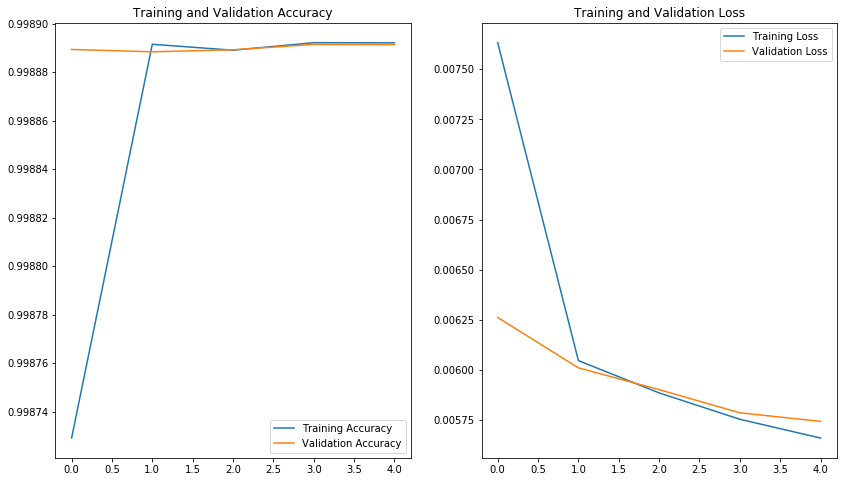

In [51]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [53]:
#baseline_model = load_model('baseline_model.h5')
y_hat = baseline_model.predict_generator(test_val_data,steps = total_val)
y_hat2 = baseline_model.predict_generator(val_data,steps = total_val)


In [54]:
# t is a threshold 
#keep every probability that is over the given threshold
t=0.16
candidate_concepts,_ = find_tags(y_hat,t)
candidate_concepts = sorted(candidate_concepts.items())
calculate_f1(candidate_concepts)

Processing concept sets...
********************************
1000 / 14157  concept sets processed...
2000 / 14157  concept sets processed...
3000 / 14157  concept sets processed...
4000 / 14157  concept sets processed...
5000 / 14157  concept sets processed...
6000 / 14157  concept sets processed...
7000 / 14157  concept sets processed...
8000 / 14157  concept sets processed...
9000 / 14157  concept sets processed...
10000 / 14157  concept sets processed...
11000 / 14157  concept sets processed...
12000 / 14157  concept sets processed...
13000 / 14157  concept sets processed...
14000 / 14157  concept sets processed...
Final result
********************************
Obtained score : 2291.719402086289 / 14157
Mean score over all concept sets : 0.16187888691716387


ΧΡΗΣΙΜΟΠΟΙΟΥΜΕ ΤΟ ΠΡΟΕΚΠΑΙΔΕΥΜΕΝΟ ΜΟΝΤΕΛΟ DENSENET-121 ΜΕ ΑΡΧΙΚΑ ΒΑΡΗ ΑΥΤΑ ΑΠΟ ΤΟ DATASET IMAGENET. ΣΤΟ ΤΕΛΟΣ ΤΟΥ CNN ΜΟΝΤΕΛΟΥ ΠΡΟΣΘΕΤΟΥΜΕ ΕΝΑ DENSE LAYER ΜΕ ΤΟΥΣ ΝΕΥΡΩΝΕΣ ΤΟΥ OUTPUT LAYER ΠΟΥ ΙΣΟΥΝΤΑΙ ΜΕ ΟΣΑ TAGS ΕΧΟΥΜΕ ΚΑΙ ΧΡΗΣΙΜΟΠΟΙΟΥΜΕ ΣΑΝ ACTIVATION FUNCTION THN SIGMOID ΑΦΟΥ ΕΧΟΥΜΕ MULTI-LABEL CLASSIFICATION PROBLEM.

In [37]:
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
base_model = tf.keras.applications.densenet.DenseNet121(include_top=False, weights='imagenet',input_shape=IMG_SHAPE,pooling='avg')

Instructions for updating:
Colocations handled automatically by placer.


In [38]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalizationV1) (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [39]:
#global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [40]:
neurons = string_con.shape[0]
prediction_layer = layers.Dense(neurons, activation='sigmoid')

In [41]:
model = tf.keras.Sequential([
  base_model,
  prediction_layer
])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 1024)              7037504   
_________________________________________________________________
dense (Dense)                (None, 5528)              5666200   
Total params: 12,703,704
Trainable params: 12,620,056
Non-trainable params: 83,648
_________________________________________________________________


ΣΑΝ OPTIMIZER ΧΡΗΣΙΜΟΠΟΙΟΥΜΕ ΤΟΝ ADAM ΜΕ ΤΙΣ ΑΡΧΙΚΕΣ ΤΟΥ ΜΕΤΑΒΛΗΤΕΣ ΚΑΙ ΕΠΙΠΛΕΟΝ ΧΡΗΣΙΜΟΠΟΙΟΥΜΕ ΤΟ ReduceLROnPlateau ΕΤΣΙ ΩΣΤΕ ΟΤΑΝ ΔΕΝ ΥΠΑΡΧΕΙ ΒΕΛΤΙΩΣΗ ΣΤΟ VALIDATION ACCURACY ΚΑΤΑ 3 ΕΠΟΧΕΣ ΝΑ ΜΕΙΩΝΟΥΜΕ ΤΟ LEARNING RATE ΚΑΤΑ 0.1 ΩΣΤΕ ΝΑ ΑΠΟΦΕΥΓΟΥΜΕ ΤΥΧΟΝ ΤΑΛΑΝΤΕΥΣΕΙΣ ΠΟΥ ΜΠΟΡΕΙ ΝΑ ΠΡΟΚΥΠΤΟΥΝ ΚΑΤΑ ΤΗΝ ΔΙΩΡΘΩΣΗ ΤΩΝ ΒΑΡΩΝ. ΤΕΛΟΣ ΧΡΗΣΙΜΟΠΟΙΟΥΜΕ ΚΑΙ ΤΗΝ EARLY STOP ΕΤΣΙ ΩΣΤΕ ΝΑ ΣΤΑΜΑΤΗΣΟΥΜΕ ΤΗΝ ΕΚΠΑΙΔΕΥΣΗ ΝΩΡΙΤΕΡΑ ΑΜΑ ΤΥΧΟΝ ΦΤΑΣΟΥΜΕ ΣΕ ΕΝΑ ΕΠΙΘΥΜΗΤΟ ΑΡΙΘΜΟ ΣΦΑΛΜΑΤΟΣ ΠΟΥ ΘΕΛΟΥΜΕ. ΧΡΗΣΙΜΟΠΟΙΟΥΜΕ 20 ΕΠΟΧΕΣ ΚΑΤΑ ΤΗΝ ΕΚΠΑΙΔΕΥΣΗ ΑΛΛΑ ΟΠΩΣ ΦΑΙΝΕΤΑΙ ΚΑΙ ΠΑΡΑΚΑΤΩ ΤΟ ΜΟΝΤΕΛΟ ΣΤΑΜΑΤΑΕΙ ΝΑ ΕΚΠΑΙΔΕΥΕΤΑΙ ΚΑΤΑ ΤΗΝ 15Η ΕΠΟΧΗ ΚΑΘΩΣ ΕΦΤΑΣΕ ΣΕ ΕΝΑ ΕΠΙΘΥΜΗΤΟ LOSS. O ΧΡΟΝΟΣ ΠΟΥ ΑΠΑΙΤΕΙΤΑΙ ΕΙΝΑΙ ΠΕΡΙΠΟΥ 1 ΩΡΑ ΓΙΑ ΚΑΘΕ ΕΠΟΧΗ ΚΑΙ ΤΕΛΟΣ ΑΦΟΥ ΟΛΟΚΛΗΡΩΘΕΙ Η ΕΚΠΑΙΔΕΥΣΗ ΑΠΟΘΗΚΕΥΟΥΜΕ ΤΟ ΜΟΝΤΕΛΟ ΜΑΣ ΚΑΙ ΤΑ ΒΑΡΗ ΤΟΥ

In [42]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              loss='binary_crossentropy',
              metrics=['accuracy'])
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto', baseline=None)
callbacks_list = [reduce_lr, early_stop]

In [43]:
import time
epochs = 3

start = time.time()
history = model.fit_generator(
    train_data,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data,
    validation_steps=total_val // batch_size,
    callbacks = callbacks_list
)
end = time.time()
print('Processing time:',(end - start)/60)

model.save_weights('best_model_weights.h5')
model.save('best_model.h5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
7079/7079 [==============================] - 3137s 443ms/step - loss: 0.0062 - acc: 0.9988 - val_loss: 0.0058 - val_acc: 0.9989
Epoch 2/3
7079/7079 [==============================] - 3104s 439ms/step - loss: 0.0054 - acc: 0.9989 - val_loss: 0.0056 - val_acc: 0.9988
Epoch 3/3
7079/7079 [==============================] - 3102s 438ms/step - loss: 0.0052 - acc: 0.9989 - val_loss: 0.0055 - val_acc: 0.9988
Processing time: 156.19777460495632


In [44]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


Text(0.5, 1.0, 'Training and Validation Loss')

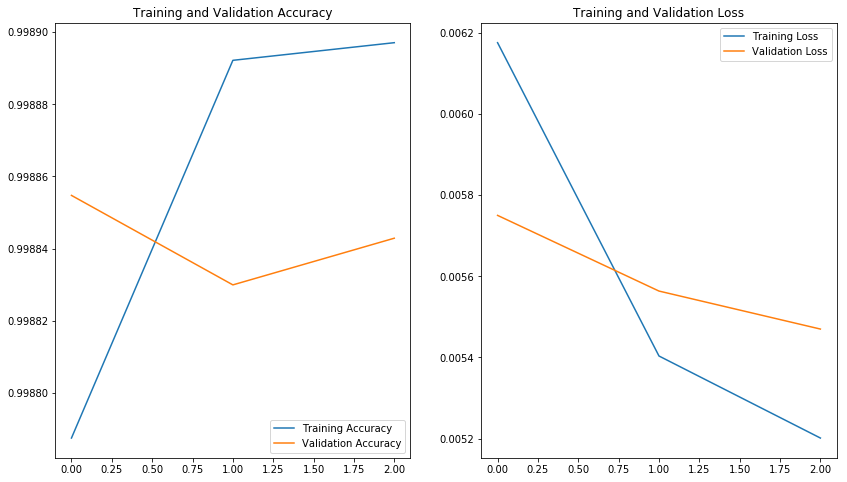

In [45]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [22]:
from tensorflow.keras.models import load_model
model = load_model('best_model.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 1024)              7037504   
_________________________________________________________________
dense (Dense)                (None, 5528)              5666200   
Total params: 12,703,704
Trainable params: 12,620,056
Non-trainable params: 83,648
_________________________________________________________________


ΠΑΡΑΠΑΝΩ ΦΟΡΤΩΝΟΥΜΕ ΤΟ ΕΚΠΑΙΔΕΥΜΕΝΟ ΜΟΝΤΕΛΟ ΚΑΙ ΚΑΝΟΥΜΕ ΠΡΟΒΛΕΨΕΙΣ ΠΑΝΩ ΣΤΑ VALIDATION DATA ΚΑΙ ΤΟ ΤΕST SET ΥΠΟΛΟΓΙΖΟΝΤΑΣ ΤΟ F1 SCORE ΠΟΥ ΠΡΟΒΛΕΠΕΙ ΤΟ ΜΟΝΤΕΛΟ

In [46]:
#y_hat = model.predict_generator(test_val_data,steps=total_val)
#y_hat2 = model.predict_generator(val_data,steps=total_val)
y_hat3 = model.predict(test_val_data)
y_hat4 = model.predict(val_data)
# t is a threshold 
#keep every probability that is over the given threshold


In [47]:
t=0.16
candidate_concepts,_ = find_tags(y_hat3,t)
candidate_concepts = sorted(candidate_concepts.items())
calculate_f1(candidate_concepts)

Processing concept sets...
********************************
1000 / 14157  concept sets processed...
2000 / 14157  concept sets processed...
3000 / 14157  concept sets processed...
4000 / 14157  concept sets processed...
5000 / 14157  concept sets processed...
6000 / 14157  concept sets processed...
7000 / 14157  concept sets processed...
8000 / 14157  concept sets processed...
9000 / 14157  concept sets processed...
10000 / 14157  concept sets processed...
11000 / 14157  concept sets processed...
12000 / 14157  concept sets processed...
13000 / 14157  concept sets processed...
14000 / 14157  concept sets processed...
Final result
********************************
Obtained score : 3143.8093328455816 / 14157
Mean score over all concept sets : 0.22206748130575557


## Assessment

* For each validation image, measure the [F1 score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) of the predicted tags. You can use the evaluation code of the competition, which can be found in the official site, in the Evaluation Methodology section of the [competition web page](https://www.imageclef.org/2019/medical/caption/). Actually that's probably the best course of action to avoid getting bogged down in differences in F1 score implementations.

* Calculate the average for all the *validation* images.

* Keep in mind that the best F1 score achieved in the competition is 0.282 for the *test* images.

* If nothing else, you can read the [paper](http://nlp.cs.aueb.gr/pubs/paper_136.pdf) to get the outline of possible solutions (but you can try your own, you do not have, and are not expected to, mimic previous work).

* After finessing your model on the validation images, you will use it on the test images.

* You must submit:

  * Your notebook, indicating the score you achieved on the validation set.

  * A file with your solutions on the test set, as explained in the Submission Instructions section of the competition web page.

ΠΑΡΑΚΑΤΩ ΚΑΝΟΥΜΕ ΠΡΟΒΛΕΨΕΙΣ ΠΑΝΩ ΣΤΟ TEST SET ΤΟ ΟΠΟΙΟ ΦΟΡΤΩΝΟΥΜΕ ΜΕΣΩ ΤΗΣ ΜΕΘΟΔΟΥ ΤΟΥ IMAGEDATAGENERATOR FLOW FROM DIRECTORY. AΦΟΥ ΠΑΡΟΥΜΕ ΤΙΣ ΠΡΟΒΛΕΨΕΙΣ ΤΟΥ ΜΟΝΤΕΛΟΥ ΜΑΣ ΤΟΤΕ ΒΡΙΣΚΟΥΜΕ ΓΙΑ ΚΑΘΕ ΕΙΚΟΝΑ ΣΤΟ TEST SET ΤΑ TAGS ΠΟΥ ΠΡΟΒΛΕΨΕ ΤΟ ΜΟΝΤΕΛΟ ΜΑΣ. ΤΕΛΟΣ, ΑΠΟΘΗΚΕΥΜΟΥΜΕ ΚΑΘΕ ΟΝΟΜΑ ΦΩΤΟΓΡΑΦΙΑΣ ΜΑΖΙ ΜΕ ΤΑ TAGS ΠΟΥ ΠΡΟΒΛΕΨΕ ΤΟ ΜΟΝΤΕΛΟ ΣΕ ΕΝΑ CSV ΑΡΧΕΙΟ

In [156]:
test_dir = 'ImageCLEF_test-set\\'
test_data = validation_image_generator.flow_from_directory(batch_size=1,
                                                              directory=test_dir,
                                                              shuffle = False
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode=None)

Found 10000 images belonging to 1 classes.


In [157]:
#extract results in test data (y_pred)
y_hat = model.predict_generator(test_data,steps = total_test)
# t is a threshold 
#keep every probability that is over the given threshold
t=0.14
candidate_concepts,_ = find_tags(y_hat,t)
candidate_concepts = sorted(candidate_concepts.items())

In [158]:
#extract as csv the results of predictions on test data
filenames=test_data.filenames
filenames = [el.replace('test-set\\','') for el in filenames]
predictions = []
for i in range(len(candidate_concepts)):
    predictions.append(candidate_concepts[i][1])
names = pd.DataFrame(filenames,columns=['Name'])
results = pd.DataFrame({'tags': predictions})
final = pd.merge(names, results, left_index=True, right_index=True)
final.to_csv("y_pred.csv",header=True,index=False, sep='\t')

## Honor Code

You understand that this is an individual assignment, and as such you must carry it out alone. You may seek help on the Internet, by Googling or searching in StackOverflow for general questions pertaining to the use of Python and pandas libraries and idioms. However, it is not right to ask direct questions that relate to the assignment and where people will actually solve your problem by answering them. You may discuss with your fellow students in order to better understand the questions, if they are not clear enough, but you should not ask them to share their answers with you, or to help you by giving specific advice.